# CNN for Tomato Leaf Disease Classification (PlantVillage)

This notebook trains (or loads) a CNN model to classify **tomato leaf** images into disease categories using the **PlantVillage – Tomatoes** subset.

**Workflow**
1. Import libraries and set hyperparameters  
2. Load and explore the Tomato subset  
3. Split into train/validation/test  
4. Build, compile, and train the CNN (or reload a saved model)  
5. Evaluate on the test set (accuracy, classification report, confusion matrix)  
6. Do basic error analysis


## 1. Imports
We import the main libraries used in this notebook: TensorFlow/Keras for the CNN, NumPy for arrays, and Matplotlib for plots.


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt


## 2. Basic configuration
Set the key hyperparameters: image size, batch size, number of channels (RGB), and training epochs.


In [2]:
image_size = (256) # 256x256 pixels
batch_size = 16 # images per batch
channels = 3 # RGB
epochs = 40 # number of training epochs


## 3. Load the dataset and exploratory data analysis
Loads images from your **Tomatoes** directory (PlantVillage subset). Each subfolder name becomes a class label automatically.

Expected layout (from the notebook folder):

- `../data/plant_village_dataset/Tomatoes/`
  - `Tomato___bacterial_spot/`
  - `Tomato___early_blight/`
  - `...`


In [3]:
# Load Tomato images from a folder structure into a tf.data.Dataset.
# Expected folder layout:
#   ../data/plant_village_dataset/Tomatoes/
#       Tomato___bacterial_spot/  (images...)
#       Tomato___early_blight/    (images...)
#       ...
# Each subfolder name becomes the class label automatically.

TOMATO_DIR = "../data/clean_data/Tomatoes"  # PlantVillage (Tomatoes subset)

dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TOMATO_DIR,                 # root folder containing one subfolder per class
    image_size=(image_size, image_size),  # resize every image to this fixed size (H, W)
    batch_size=batch_size,                # how many images per batch returned by the dataset
    label_mode="int",                     # integer labels (0..n_classes-1)
    shuffle=True,
    seed=12,
)

# Result:
# - dataset yields batches of (images, labels)
# - images shape: (batch_size, image_size, image_size, 3)
# - labels are integer class IDs (e.g., 0..num_classes-1)


Found 16694 files belonging to 10 classes.


### Class names
Keras assigns an integer label to each class based on folder order. `class_names` stores the mapping.


In [4]:
# Get the list of class (label) names inferred from the subfolder names
# inside the Tomatoes directory.
# Example: ["Tomato___healthy", "Tomato___late_blight", ...]
class_names = dataset.class_names

# Display / print the class names (in notebooks, the last line shows the value)
class_names


['Tomato___Leaf_mold',
 'Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___mosaic_virus',
 'Tomato___septoria_leaf_spot',
 'Tomato___spider_mites_two-spotted_spider_mite',
 'Tomato___target_spot',
 'Tomato___yellow_leaf_curl_virus']

In [5]:
from pathlib import Path

TOMATO_DIR = Path(TOMATO_DIR)  # convert str -> Path
# or set it directly:
# TOMATO_DIR = Path("../data/plant_village_dataset/Tomatoes")

counts = {}
for class_dir in sorted([p for p in TOMATO_DIR.iterdir() if p.is_dir()]):
    n = sum(1 for f in class_dir.rglob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"])
    counts[class_dir.name] = n

for k, v in counts.items():
    print(f"{k}: {v}")

print("\nTotal images:", sum(counts.values()))
print("Num classes:", len(counts))


Tomato___bacterial_spot: 2338
Tomato___early_blight: 1079
Tomato___healthy: 1693
Tomato___late_blight: 2107
Tomato___Leaf_mold: 1104
Tomato___mosaic_virus: 414
Tomato___septoria_leaf_spot: 1911
Tomato___spider_mites_two-spotted_spider_mite: 1665
Tomato___target_spot: 1404
Tomato___yellow_leaf_curl_virus: 2979

Total images: 16694
Num classes: 10


### Inspect one batch
Checks the tensor shapes coming from the dataset and prints the label ids in that batch.


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)   # image batch shape
    print(label_batch.numpy()) # labels as numpy


(16, 256, 256, 3)
[6 4 1 1 3 7 1 3 8 2 3 9 1 8 6 1]


### Inspect one image shape
Shows the shape of a single image tensor (height, width, channels).


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


### Inspect raw pixel values
Prints raw pixel values for one image (before rescaling).


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())  # pixel values (array) of the first image in the batch



[[[112. 104. 102.]
  [112. 104. 102.]
  [114. 106. 104.]
  ...
  [114. 104. 102.]
  [111. 101.  99.]
  [111. 101.  99.]]

 [[111. 103. 101.]
  [110. 102. 100.]
  [110. 102. 100.]
  ...
  [115. 105. 103.]
  [113. 103. 101.]
  [114. 104. 102.]]

 [[117. 109. 107.]
  [113. 105. 103.]
  [112. 104. 102.]
  ...
  [112. 102. 100.]
  [112. 102. 100.]
  [113. 103. 101.]]

 ...

 [[145. 139. 141.]
  [147. 141. 143.]
  [150. 144. 146.]
  ...
  [155. 146. 149.]
  [153. 144. 147.]
  [152. 143. 146.]]

 [[145. 139. 141.]
  [147. 141. 143.]
  [150. 144. 146.]
  ...
  [165. 156. 159.]
  [164. 155. 158.]
  [157. 148. 151.]]

 [[157. 151. 153.]
  [154. 148. 150.]
  [152. 146. 148.]
  ...
  [155. 146. 149.]
  [153. 144. 147.]
  [143. 134. 137.]]]


### Visualize a sample image
Displays one example image from the dataset.


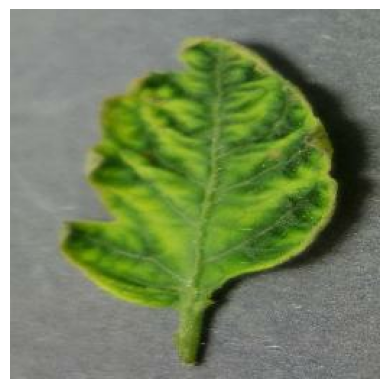

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # show first image (convert to uint8 for display)
    plt.axis("off")                                      # hide axes


### Label id → class name mapping
Prints the numeric label id for each class. **Note:** this cell previously contained extra code; it has been cleaned to only show the mapping.


In [10]:
for label_id, class_name in enumerate(dataset.class_names):
    print(f"{label_id} : {class_name}")  # print: class_index : class_name



0 : Tomato___Leaf_mold
1 : Tomato___bacterial_spot
2 : Tomato___early_blight
3 : Tomato___healthy
4 : Tomato___late_blight
5 : Tomato___mosaic_virus
6 : Tomato___septoria_leaf_spot
7 : Tomato___spider_mites_two-spotted_spider_mite
8 : Tomato___target_spot
9 : Tomato___yellow_leaf_curl_virus


### Collect one sample per class
Unbatches the dataset and stores the first image seen for each class. This is useful for later visualization.


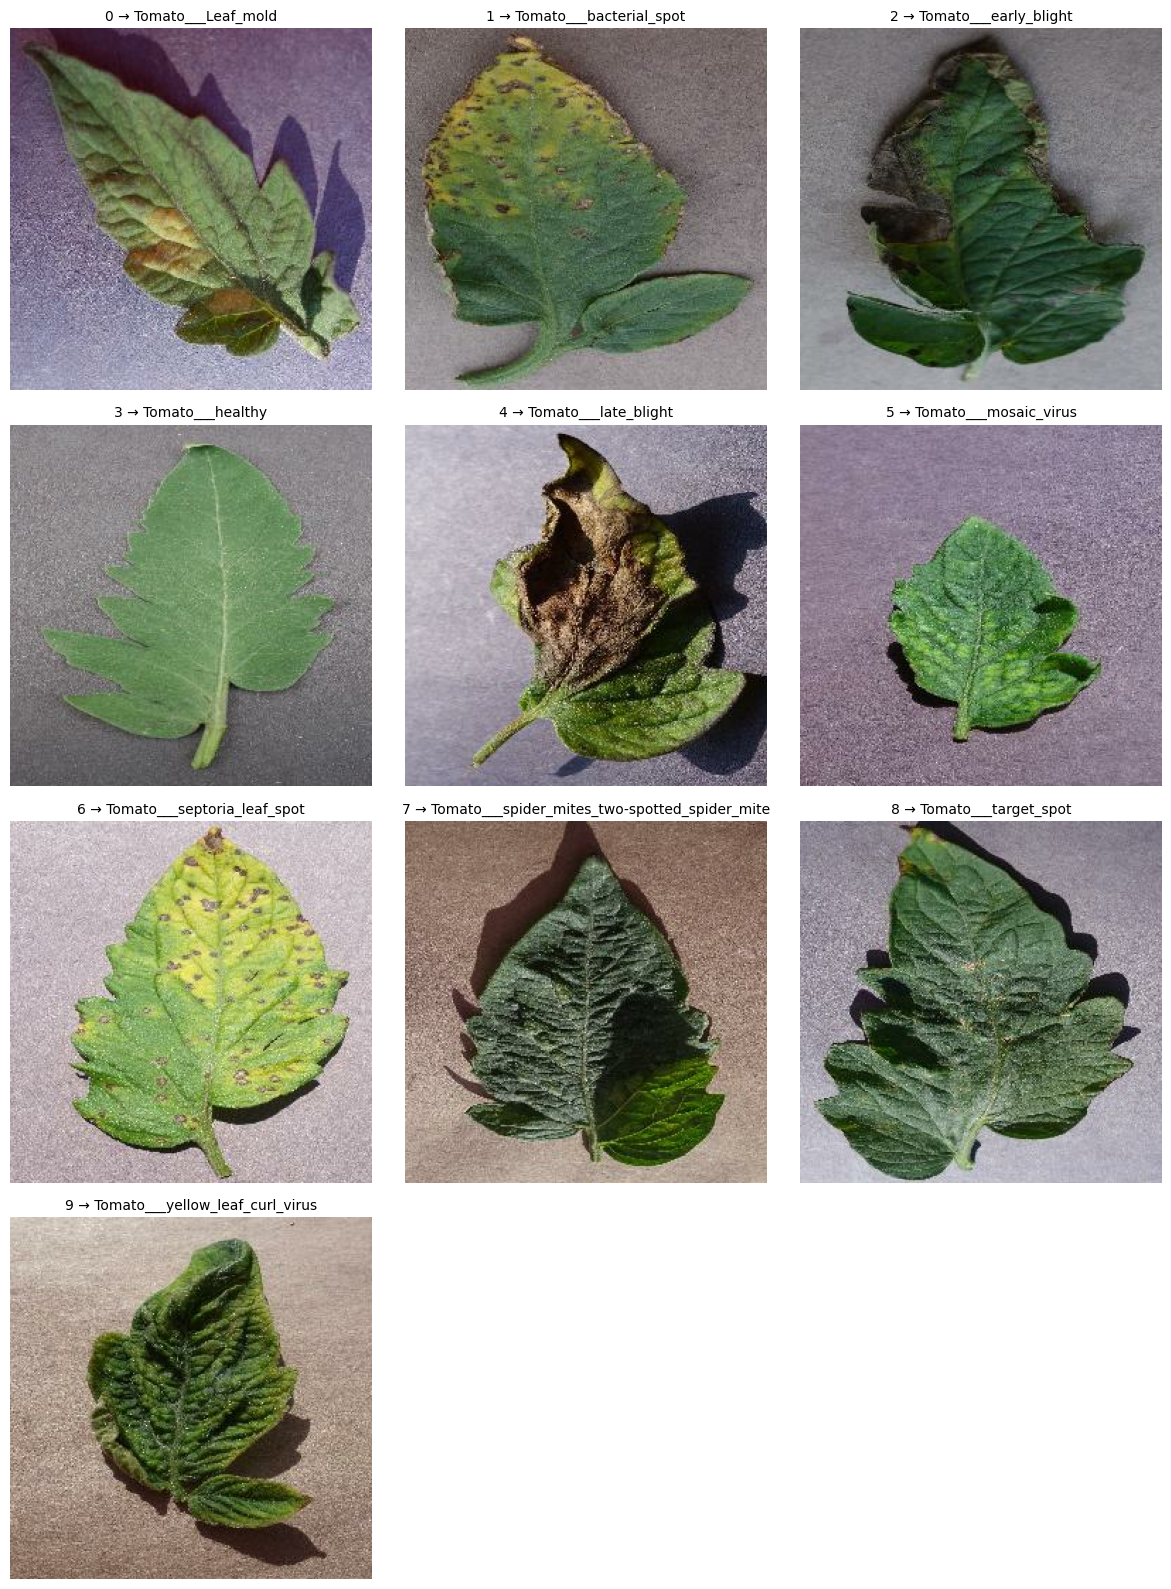

In [11]:
import math

class_names = dataset.class_names                 # class names (from folder names)
num_classes = len(class_names)                    # number of classes

samples = {}                                      # store 1 sample image per class

for img, label in dataset.unbatch():              # iterate image-by-image (not in batches)
    label_id = int(label.numpy())                 # tensor -> int
    if label_id not in samples:
        samples[label_id] = img                   # keep the first image for this class
    if len(samples) == num_classes:
        break                                     # stop after collecting all classes

cols = 3
rows = math.ceil(num_classes / cols)              # rows needed for the grid

plt.figure(figsize=(4*cols, 4*rows))
for i, label_id in enumerate(sorted(samples.keys())):
    ax = plt.subplot(rows, cols, i + 1)           # position in the grid

    img = samples[label_id].numpy().astype("uint8")  # convert to display format
    plt.imshow(img)                               # show image
    plt.title(f"{label_id} → {class_names[label_id]}", fontsize=10)  # label + name
    plt.axis("off")                               # hide axes

plt.tight_layout()                                # nicer spacing
plt.show()                                        # render the figure


## 4. Train/validation/test split
Splits a `tf.data.Dataset` into train/val/test using `take()` and `skip()`. This assumes the dataset has a known length.


In [12]:
def spliting_the_data(ds, train_split=0.80, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)                          # total number of batches/elements in ds

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # shuffle before splitting

    train_size = int(train_split * ds_size)    # number of items for train
    val_size   = int(val_split * ds_size)      # number of items for val

    train_ds = ds.take(train_size)             # first part -> train
    val_ds   = ds.skip(train_size).take(val_size)  # next part -> val
    test_ds  = ds.skip(train_size).skip(val_size)  # remaining -> test

    return train_ds, val_ds, test_ds           # return the 3 datasets


### Create the splits
Runs the split function and produces `train_ds`, `val_ds`, and `test_ds`.


In [13]:
train_ds, val_ds, test_ds = spliting_the_data(dataset)  # split dataset into train/val/test



### Check split sizes
Shows the number of batches in each split (may be `unknown` in some pipelines).


In [14]:
len(train_ds), len(val_ds), len(test_ds)  # number of batches/items in each split

(835, 104, 105)

## 4b. Handle class imbalance (class weights + optional light oversampling)

Plant disease datasets are often imbalanced (some diseases have many more images than others). Two practical strategies are:

- **Class weights (recommended first):** increases the loss contribution of minority classes.
- **Light oversampling (optional):** slightly increases the sampling probability of minority classes **in training only**.

Keep validation/test sets unchanged so evaluation remains honest.


In [15]:
from collections import Counter
import numpy as np

# -----------------------------
# Compute per-class counts on TRAIN split
# -----------------------------
label_counter = Counter()
for _, y in train_ds:
    label_counter.update(y.numpy().tolist())

num_classes = len(class_names)
train_total = sum(label_counter.values())

print("Images per class in TRAIN:")
for i, name in enumerate(class_names):
    print(f"{i:2d}  {name:45s}  count={label_counter[i]:5d}")

# -----------------------------
# Class weights (balanced)
# w_i = N / (K * n_i)
# -----------------------------
class_weight = {i: train_total / (num_classes * label_counter[i]) for i in range(num_classes)}

print("\nClass weights:")
for i, name in enumerate(class_names):
    print(f"{i:2d}  {name:45s}  weight={class_weight[i]:.3f}")

# -----------------------------
# Optional: light oversampling (training only)
# Set USE_OVERSAMPLING=True if you want a gentle rebalancing.
# -----------------------------
USE_OVERSAMPLING = False
alpha = 0.25  # 0.0 = no oversampling, 1.0 = fully uniform; 0.15–0.35 is usually "light"

if USE_OVERSAMPLING:
    # Get batch size from one batch
    for xb, yb in train_ds.take(1):
        BATCH_SIZE = int(xb.shape[0])
        break

    initial_dist = np.array([label_counter[i] for i in range(num_classes)], dtype=np.float64)
    initial_dist = initial_dist / initial_dist.sum()

    uniform = np.ones(num_classes, dtype=np.float64) / num_classes
    target_dist = (1 - alpha) * initial_dist + alpha * uniform

    resampler = tf.data.experimental.rejection_resample(
        class_func=lambda x, y: y,
        target_dist=target_dist,
        initial_dist=initial_dist,
        seed=42,
    )

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds_balanced = (
        train_ds
        .unbatch()
        .apply(resampler)  # (resampled_class, (x, y))
        .map(lambda _cls, data: data, num_parallel_calls=AUTOTUNE)
        .shuffle(2000, seed=42, reshuffle_each_iteration=True)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
else:
    train_ds_balanced = train_ds


Images per class in TRAIN:
 0  Tomato___Leaf_mold                             count=  889
 1  Tomato___bacterial_spot                        count= 1890
 2  Tomato___early_blight                          count=  868
 3  Tomato___healthy                               count= 1358
 4  Tomato___late_blight                           count= 1646
 5  Tomato___mosaic_virus                          count=  341
 6  Tomato___septoria_leaf_spot                    count= 1514
 7  Tomato___spider_mites_two-spotted_spider_mite  count= 1334
 8  Tomato___target_spot                           count= 1142
 9  Tomato___yellow_leaf_curl_virus                count= 2368

Class weights:
 0  Tomato___Leaf_mold                             weight=1.502
 1  Tomato___bacterial_spot                        weight=0.706
 2  Tomato___early_blight                          weight=1.538
 3  Tomato___healthy                               weight=0.983
 4  Tomato___late_blight                           weight=0.811
 5  Tom

## 5. Preprocessing and data augmentation

- **Resizing** ensures all images have the same shape.
- **Augmentation** introduces realistic variation (flip/rotate/zoom/shift/contrast/noise) to improve generalization.
- **EfficientNet preprocessing** applies the normalization expected by ImageNet-pretrained weights (via `preprocess_input`).



In [16]:
# -----------------------------
# Preprocessing + data augmentation (Transfer Learning)
# -----------------------------
# For EfficientNet, we will:
# 1) Resize to a fixed shape
# 2) Apply augmentation (train-time only)
# 3) Apply EfficientNet preprocess_input (normalization expected by ImageNet weights)

resize_only = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
], name="resize_only")

# Realistic augmentation for phone photos (keep symptoms intact).
# If validation accuracy drops too much, reduce rotation/translation/contrast.

def _light_color_jitter(x):
    # Works regardless of input dtype/range by normalizing to [0,1] inside.
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.image.random_brightness(x, max_delta=0.12)
    x = tf.image.random_contrast(x, lower=0.85, upper=1.15)
    x = tf.image.random_saturation(x, lower=0.85, upper=1.15)
    x = tf.clip_by_value(x, 0.0, 1.0)
    return x * 255.0


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.20),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.10, 0.10),
    layers.RandomContrast(0.20),
    layers.Lambda(_light_color_jitter, name="light_color_jitter"),
    layers.GaussianNoise(0.03),
], name="data_augmentation")

# EfficientNet expects a specific normalization (preprocess_input)
preprocess_input = layers.Lambda(
    tf.keras.applications.efficientnet.preprocess_input,
    name="efficientnet_preprocess"
)


## 6. Build the Transfer Learning model (EfficientNetB0)

### Model architecture
We use **transfer learning** with an ImageNet-pretrained **EfficientNetB0** backbone.

- Stage 1: freeze the backbone and train a small classification head.
- Stage 2: unfreeze the top layers and fine-tune with a small learning rate.


In [17]:
input_shape = (image_size, image_size, channels)

# Class labels (folder names)
class_names = dataset.class_names
n_classes = len(class_names)

# -----------------------------
# Transfer Learning backbone
# -----------------------------
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
base_model.trainable = False  # Stage 1: feature extractor

# -----------------------------
# Build the full model (Functional API)
# -----------------------------
inputs = layers.Input(shape=input_shape, name='input_image')
x = resize_only(inputs)
x = data_augmentation(x)
x = preprocess_input(x)

# Important: keep BatchNorm layers in inference mode while frozen
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
x = layers.Dropout(0.30, name='dropout')(x)
outputs = layers.Dense(n_classes, activation='softmax', name='predictions')(x)

model = tf.keras.Model(inputs, outputs, name='EfficientNetB0_tomato_transfer')

model.summary()



Model: "EfficientNetB0_tomato_transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 resize_only (Sequential)    (None, 256, 256, 3)       0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 efficientnet_preprocess (L  (None, 256, 256, 3)       0         
 ambda)                                                          
                                                                 
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                   

### Compile the model
Sets the optimizer, loss function, and metrics. `SparseCategoricalCrossentropy` is correct when labels are integer-encoded.


In [18]:
# -----------------------------
# Compile (Stage 1)
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc'),
    ],
)

model.summary()


Model: "EfficientNetB0_tomato_transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 resize_only (Sequential)    (None, 256, 256, 3)       0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 efficientnet_preprocess (L  (None, 256, 256, 3)       0         
 ambda)                                                          
                                                                 
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                    

### Early stopping 

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # training callbacks

# Ensure the models folder exists
os.makedirs("../models", exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",              # watch validation loss
        mode="min",                      # lower is better
        patience=9,                      # stop if no improvement for 9 epochs
        restore_best_weights=True        # keep best weights found
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "../models/best_tomato_EfficientNetB0_model.keras",              # file to save best model
        monitor="val_loss",
        mode="min",
        save_best_only=True              # save only when val_loss improves
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,                      # reduce LR by half
        patience=2,                      # wait 2 epochs without improvement
        min_lr=1e-6,                     # don't go below this LR
        verbose=1                        # print when LR changes
    )
]


### GPU setup (optional)
Enables memory growth so TensorFlow doesn't reserve all GPU memory at once.


In [20]:
import tensorflow as tf  # TensorFlow library

gpus = tf.config.list_physical_devices('GPU')          # list available GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # use GPU memory as needed (avoid full pre-allocation)

print("GPUs:", gpus)                                   # show detected GPUs



GPUs: []


### Train or load a saved model
Use `TRAIN = True` to train and save, or `TRAIN = False` to load the saved model from disk. This cell also prints TensorFlow/Keras versions and some file info.


In [24]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import tensorflow as tf

MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = str(MODEL_DIR / '01_tomato_disease_EfficientNetB0_model.keras')
TRAIN = True

# Two-stage training
INITIAL_EPOCHS = min(10, epochs)                    # Stage 1: train head (backbone frozen)
FINE_TUNE_EPOCHS = max(0, epochs - INITIAL_EPOCHS)  # Stage 2: fine-tune top layers

if TRAIN:
    print('Stage 1/2: training classifier head (backbone frozen)...')
    hist1 = model.fit(
        train_ds_balanced,
        validation_data=val_ds,
        epochs=INITIAL_EPOCHS,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1,
    )

    # -----------------------------
    # Stage 2: fine-tuning
    # -----------------------------
    if FINE_TUNE_EPOCHS > 0:
        print('\nStage 2/2: fine-tuning (unfreeze top layers)...')
        base_model.trainable = True

        # Freeze the first ~70% of the backbone and fine-tune the top ~30%.
        fine_tune_at = int(len(base_model.layers) * 0.7)
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Re-compile with a smaller learning rate for fine-tuning
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[
                'accuracy',
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc'),
            ],
        )

        hist2 = model.fit(
            train_ds_balanced,
            validation_data=val_ds,
            epochs=epochs,
            initial_epoch=hist1.epoch[-1] + 1,
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=1,
        )
    else:
        hist2 = None

    # Save model (note: if EarlyStopping has restore_best_weights=True, this saves best weights)
    model.save(MODEL_PATH)

    # Save class names for Streamlit / inference (keeps label order consistent)
    (MODEL_DIR / 'tomato_class_names.json').write_text(
        json.dumps(class_names, indent=2),
        encoding='utf-8'
    )

    # Save training history to CSV
    df1 = pd.DataFrame(hist1.history)
    df1['epoch'] = np.arange(1, len(df1) + 1)

    if hist2 is not None:
        df2 = pd.DataFrame(hist2.history)
        df2['epoch'] = np.arange(df1['epoch'].max() + 1, df1['epoch'].max() + 1 + len(df2))
        hist_df = pd.concat([df1, df2], ignore_index=True)
    else:
        hist_df = df1

    hist_df.to_csv(str(MODEL_DIR / 'training_history.csv'), index=False)

    print('Saved model to:', MODEL_PATH)
    print('Saved class names to:', str(MODEL_DIR / 'tomato_class_names.json'))
    print('Saved history to:', str(MODEL_DIR / 'training_history.csv'))

else:
    if os.path.exists(MODEL_PATH):
        print('Loading saved model...')
        try:
            model = tf.keras.models.load_model(MODEL_PATH, compile=False, safe_mode=False)
        except TypeError:
            model = tf.keras.models.load_model(MODEL_PATH, compile=False)
        print('Loaded model from:', MODEL_PATH)
    else:
        raise FileNotFoundError(
            f"Model not found at: {MODEL_PATH}\n"
            'Either fix the path or set TRAIN=True to train and save the model.'
        )


Stage 1/2: training classifier head (backbone frozen)...
Epoch 1/10


835/835 [==============================] - 810s 858ms/step - loss: 1.0784 - accuracy: 0.6840 - top3_acc: 0.8922 - val_loss: 0.7649 - val_accuracy: 0.7470 - val_top3_acc: 0.9465 - lr: 0.0010
Epoch 2/10
835/835 [==============================] - 793s 857ms/step - loss: 0.6850 - accuracy: 0.8005 - top3_acc: 0.9530 - val_loss: 0.6307 - val_accuracy: 0.7903 - val_top3_acc: 0.9543 - lr: 0.0010
Epoch 3/10
835/835 [==============================] - 783s 847ms/step - loss: 0.5974 - accuracy: 0.8196 - top3_acc: 0.9631 - val_loss: 0.5057 - val_accuracy: 0.8425 - val_top3_acc: 0.9645 - lr: 0.0010
Epoch 4/10
835/835 [==============================] - 816s 875ms/step - loss: 0.5488 - accuracy: 0.8321 - top3_acc: 0.9660 - val_loss: 0.5331 - val_accuracy: 0.8197 - val_top3_acc: 0.9681 - lr: 0.0010
Epoch 5/10
835/835 [==============================] - 841s 916ms/step - loss: 0.5146 - accuracy: 0.8378 - top3_acc: 0.9697 - val_loss: 0.

### Testing and model evaluation
Returns test loss and test accuracy.


In [25]:
if "scores" not in globals():
    model.evaluate(test_ds, verbose=1)
else:
    print("✅ Using cached scores (not re-evaluating).")

print("metrics:", model.metrics_names)


105/105 [==============================] - 136s 477ms/step - loss: 0.1518 - accuracy: 0.9506 - top3_acc: 0.9946
metrics: ['loss', 'accuracy', 'top3_acc']


### Predict labels on the test set
Collects true labels and predicted labels so we can build a classification report and confusion matrix.


In [26]:
y_true_list = []                      # store true labels from all batches
y_pred_list = []                      # store predicted labels from all batches

for x_batch, y_batch in test_ds:      # loop over test batches (images, labels)
    probs = model.predict(x_batch, verbose=0)   # predicted class probabilities
    y_pred_batch = np.argmax(probs, axis=1)     # pick class with highest probability

    y_true_batch = y_batch.numpy()    # true labels as numpy

    y_true_list.append(y_true_batch)  # collect true labels
    y_pred_list.append(y_pred_batch)  # collect predicted labels

y_true = np.concatenate(y_true_list)  # merge all true labels into one array
y_pred = np.concatenate(y_pred_list)  # merge all predictions into one array

print("Manual test accuracy:", (y_true == y_pred).mean())  # compare with model.evaluate accuracy


Manual test accuracy: 0.9577380952380953


### Confusion matrix plot
Shows where the model confuses one class for another.


<Figure size 1000x800 with 0 Axes>

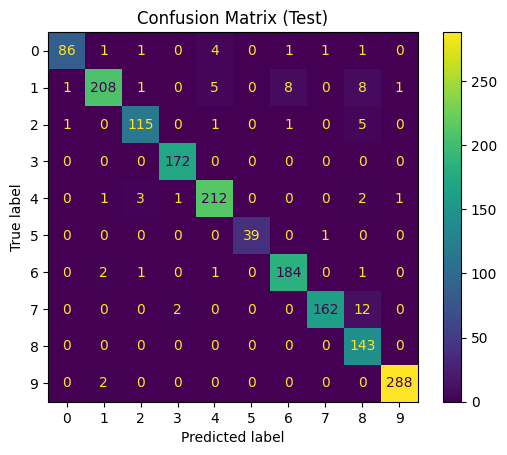

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # confusion matrix tools

cm = confusion_matrix(y_true, y_pred)      # build confusion matrix from true vs predicted labels

plt.figure(figsize=(10, 8))               # set figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # wrap matrix for plotting
disp.plot(values_format="d")              # plot counts as integers
plt.title("Confusion Matrix (Test)")      # title
plt.show()                                # display plot


### Classification report
Precision/recall/F1-score per class, plus macro and weighted averages.


In [28]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix

print(classification_report(
    y_true, y_pred,                    # true labels vs predicted labels
    target_names=class_names,          # show class names instead of numbers
    digits=4                           # print metrics with 4 decimals
))



                                               precision    recall  f1-score   support

                           Tomato___Leaf_mold     0.9773    0.9053    0.9399        95
                      Tomato___bacterial_spot     0.9720    0.8966    0.9327       232
                        Tomato___early_blight     0.9504    0.9350    0.9426       123
                             Tomato___healthy     0.9829    1.0000    0.9914       172
                         Tomato___late_blight     0.9507    0.9636    0.9571       220
                        Tomato___mosaic_virus     1.0000    0.9750    0.9873        40
                  Tomato___septoria_leaf_spot     0.9485    0.9735    0.9608       189
Tomato___spider_mites_two-spotted_spider_mite     0.9878    0.9205    0.9529       176
                         Tomato___target_spot     0.8314    1.0000    0.9079       143
              Tomato___yellow_leaf_curl_virus     0.9931    0.9931    0.9931       290

                                     accu

### Inspect wrong predictions
Collects a few misclassified examples so you can visually check what went wrong.


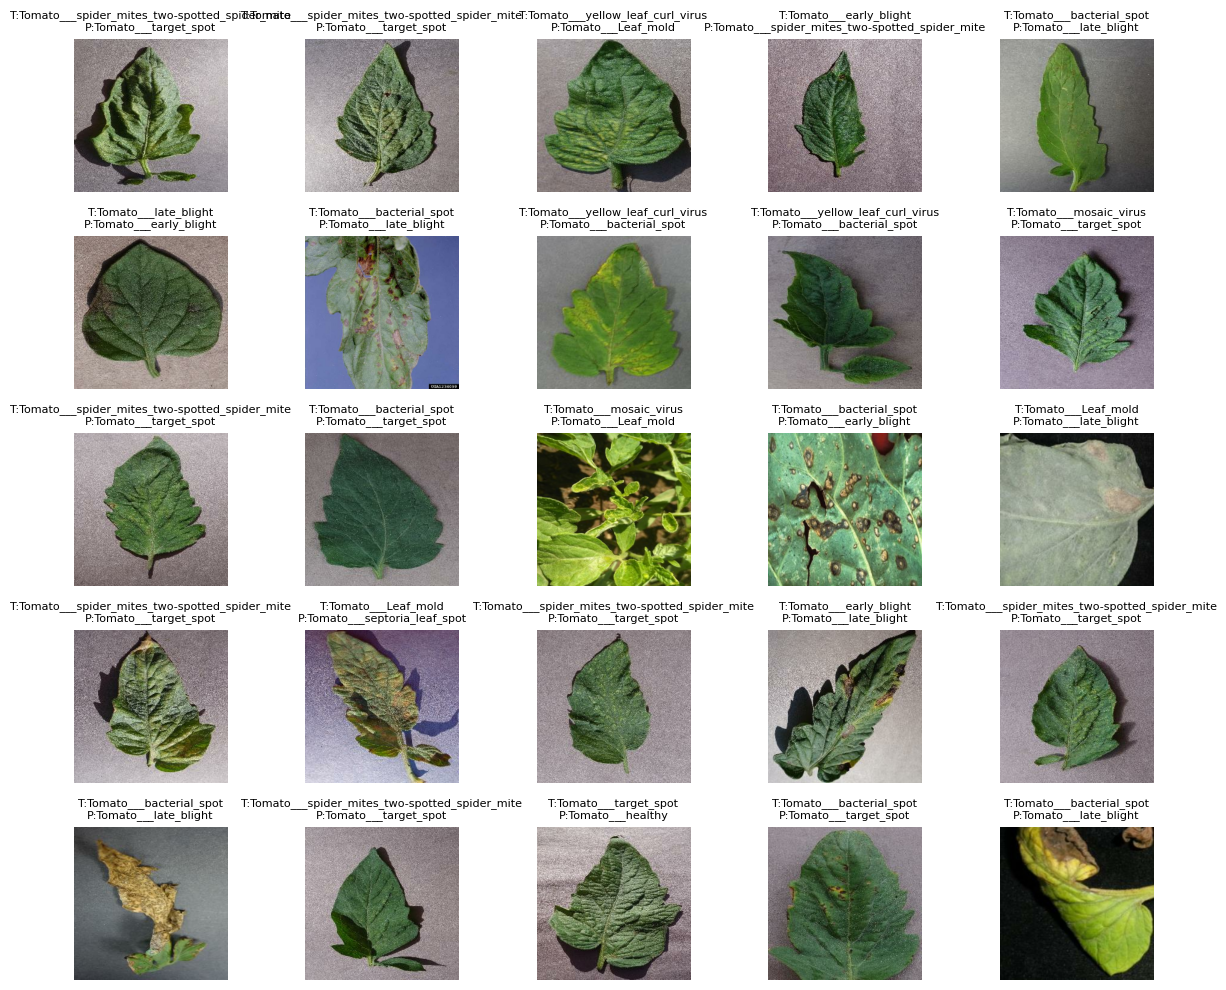

In [29]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # arrays

wrong = []  # store (image, true_label, pred_label) for mistakes

for x_batch, y_batch in test_ds:                      # loop over test batches
    probs = model.predict(x_batch, verbose=0)         # predict probabilities
    pred = np.argmax(probs, axis=1)                   # predicted class ids

    if len(y_batch.shape) > 1 and y_batch.shape[-1] > 1:  # if labels are one-hot
        true = np.argmax(y_batch.numpy(), axis=1)          # convert to class ids
    else:
        true = y_batch.numpy().astype(int)                 # sparse labels -> int

    for i in range(len(true)):                             # check each item in batch
        if true[i] != pred[i]:
            wrong.append((x_batch[i].numpy().astype("uint8"), true[i], pred[i]))  # save mistake
    if len(wrong) >= 25:
        break                                              # stop after collecting 25 mistakes

plt.figure(figsize=(12, 10))                               # create figure
for i, (img, t, p) in enumerate(wrong[:25]):               # plot up to 25 wrong images
    plt.subplot(5, 5, i+1)
    plt.imshow(img)                                       # show image
    t_name = class_names[t] if "class_names" in globals() else str(t)  # true name
    p_name = class_names[p] if "class_names" in globals() else str(p)  # pred name
    plt.title(f"T:{t_name}\nP:{p_name}", fontsize=8)       # title (T=true, P=pred)
    plt.axis("off")                                       # hide axes
plt.tight_layout()                                        # spacing
plt.show()                                                # display


### Error analysis 

In [30]:
import numpy as np  # arrays + numerical ops

pairs = []                          # store (count, true_class_name, predicted_class_name)
n = len(class_names)                # number of classes

for i in range(n):                  # loop over true class index
    for j in range(n):              # loop over predicted class index
        if i != j and cm[i, j] > 0: # keep only mistakes (off-diagonal) with count > 0
            pairs.append((cm[i, j], class_names[i], class_names[j]))  # save this confusion pair

for c, true_name, pred_name in sorted(pairs, reverse=True)[:15]:  # top 15 biggest confusions
    print(f"{c:>3}  True: {true_name:30s}  → Pred: {pred_name}")   # print nicely formatted


 12  True: Tomato___spider_mites_two-spotted_spider_mite  → Pred: Tomato___target_spot
  8  True: Tomato___bacterial_spot         → Pred: Tomato___target_spot
  8  True: Tomato___bacterial_spot         → Pred: Tomato___septoria_leaf_spot
  5  True: Tomato___early_blight           → Pred: Tomato___target_spot
  5  True: Tomato___bacterial_spot         → Pred: Tomato___late_blight
  4  True: Tomato___Leaf_mold              → Pred: Tomato___late_blight
  3  True: Tomato___late_blight            → Pred: Tomato___early_blight
  2  True: Tomato___yellow_leaf_curl_virus  → Pred: Tomato___bacterial_spot
  2  True: Tomato___spider_mites_two-spotted_spider_mite  → Pred: Tomato___healthy
  2  True: Tomato___septoria_leaf_spot     → Pred: Tomato___bacterial_spot
  2  True: Tomato___late_blight            → Pred: Tomato___target_spot
  1  True: Tomato___septoria_leaf_spot     → Pred: Tomato___target_spot
  1  True: Tomato___septoria_leaf_spot     → Pred: Tomato___late_blight
  1  True: Tomato___sep

The remaining errors are usually concentrated in a few **visually similar** categories.
Use the printed **top confusion pairs** above to decide what to improve next:

- Add/clean data for the confused classes
- Tune augmentation strength (too weak → overfit; too strong → underfit)
- Increase model capacity or switch to transfer learning (e.g., ResNet/MobileNet)
- Consider higher input resolution if symptoms are very small
